In [298]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import random
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


In [299]:
def define_files():
    files = {
        "air_pollution_death": "data/air_pollution_death.csv",
        "transportation": 'data/road-transportation_country_emissions.csv',
        "coal": 'data/coal-mining_country_emissions.csv',
        "cropland": 'data/cropland-fires_country_emissions.csv',
        "residential_commercial": 'data/residential-and-commercial-onsite-fuel-usage_country_emissions.csv',
        "forest_clearing": 'data/forest-land-clearing_country_emissions.csv',
        "petrochemicals": 'data/petrochemicals_country_emissions.csv',
        "electricity_generation": 'data/electricity-generation_country_emissions.csv',
        "incineration_open_burning": 'data/incineration-and-open-burning-of-waste_country_emissions.csv',
        "health_expenditure": 'data/health-expenditure.csv',
        "urban_population": 'data/urban-population.csv'
    }
    return files

files = define_files()


In [300]:
# Finding common country codes

environment_factor_files_list = [
        'transportation',
        'coal',
        'cropland',
        'residential_commercial',
        'forest_clearing',
        'petrochemicals',
        'electricity_generation',
        'incineration_open_burning'
    ]
    
socioeconomic_files_list = [
    'health_expenditure',
    'urban_population'
]

def find_common_country_codes(env_list, socio_list, files):
    env_codes = []
    socio_codes = []
    
    for factor in env_list:
        df = pd.read_csv(files[factor])
        codes = set(df['iso3_country'].unique())
        env_codes.append(codes)
    common_env_codes = set.intersection(*env_codes) if env_codes else set()


    for factor in socio_list:
        df = pd.read_csv(files[factor], skiprows=4)
        codes = set(df['Country Code'].unique())
        socio_codes.append(codes)
    common_socio_codes = set.intersection(*socio_codes) if socio_codes else set()

    common_country_codes = sorted(list(common_env_codes.intersection(common_socio_codes)))
    return common_country_codes

common_country_codes = find_common_country_codes(environment_factor_files_list, socioeconomic_files_list, files)


In [301]:
# Filtering Air Pollution data (from air_pollution_death.csv)

air_pollution_df = pd.read_csv(files['air_pollution_death'])

filtered_air_pollution_df = air_pollution_df[
    (air_pollution_df['SpatialDimValueCode'].isin(common_country_codes)) &
    (air_pollution_df['Period'] == 2018) &
    (air_pollution_df['Dim1'] == 'Both sexes')
]


In [302]:
# Filtering feature data and aggregating feature values per country

environment_data = []
socioeconomic_data = []

for factor in environment_factor_files_list:
    df = pd.read_csv(files[factor])

    df_filtered = df[
        (df['iso3_country'].isin(common_country_codes)) &
        (df['start_time'] >= '2018-01-01 00:00:00')
    ]
    
    df_grouped = df_filtered.groupby('iso3_country', as_index=False)['emissions_quantity'].sum()
    df_grouped.rename(columns={'iso3_country': 'Country Code', 'emissions_quantity': factor}, inplace=True)
    environment_data.append(df_grouped)

for factor in socioeconomic_files_list:
    df = pd.read_csv(files[factor], skiprows=4)

    df_filtered = df[df['Country Code'].isin(common_country_codes)]
    df_filtered = df_filtered[['Country Code', '2018']].rename(columns={'2018': factor})
    socioeconomic_data.append(df_filtered)



In [303]:
# Merging all features into one data frame

deaths_by_country = filtered_air_pollution_df.groupby(['SpatialDimValueCode'])['FactValueNumeric'].sum().reset_index()
deaths_by_country.rename(columns={'SpatialDimValueCode': 'Country Code', 'FactValueNumeric': 'Air Pollution Deaths'}, inplace=True)

environment_merged = environment_data[0]
for df in environment_data[1:]:
    environment_merged = pd.merge(environment_merged, df, on='Country Code', how='outer')

final_merged = environment_merged
for df in socioeconomic_data:
    final_merged = pd.merge(final_merged, df, on='Country Code', how='outer')

final_merged = pd.merge(final_merged, deaths_by_country, on='Country Code', how='outer')
final_merged = final_merged.dropna()
factors = final_merged
final_merged_with_outlier = final_merged
final_merged = final_merged[final_merged['Country Code'] != 'CHN']
final_merged = final_merged[final_merged['Country Code'] != 'IND']
# final_merged.head()

In [304]:
rename_dict = {
    "transportation": "Transportation Emissions",
    "coal": "Coal Mining Emissions",
    "cropland": "Cropland Fires Emissions",
    "residential_commercial": "Residential & Commercial Emissions",
    "forest_clearing": "Forest Clearing Emissions",
    "petrochemicals": "Petrochemicals Emissions",
    "electricity_generation": "Electricity Generation Emissions",
    "incineration_open_burning": "Incineration & Open Burning Emissions",
    "health_expenditure": "Health Expenditure",
    "urban_population": "Urban Population"
}

# Rename the columns in the DataFrame
final_merged.rename(columns=rename_dict, inplace=True)
final_merged_with_outlier.rename(columns=rename_dict, inplace=True)


In [ ]:
# Determining X and y values and applying dataset standardization

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

X = final_merged.drop(columns=['Country Code', 'Air Pollution Deaths'])
y = final_merged['Air Pollution Deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [306]:
# Creating, training, and testing the model

# {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.3, 'gamma': 0, 'reg_alpha': 100, 'reg_lambda': 1, 'train_r2': 0.974334007523811, 'test_r2': 0.8997231261698432}
#PARAMETERS WHEN EXCLUDING CHINA AND INDIA
model = xgb.XGBRegressor(
    tree_method='hist',
    n_estimators=200, #600
    learning_rate=0.065, #0.065
    max_depth=3, #1
    gamma=0, #1
    
    subsample=0.3, #0.042
    colsample_bytree=0.7, #1
    reg_alpha=10, #80000
    reg_lambda=10, #60
    random_state=random_seed
)

'''
#Best Hyperparameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.3, 'gamma': 0, 'colsample_bytree': 0.7, 'reg_alpha': 1000, 'reg_lambda': 1, 'train_r2': 0.9582780966393493, 'test_r2': 0.6115232954800243}
# PARAMETERS WHEN INCLUDING CHINA AND INDIA
model = xgb.XGBRegressor(
    tree_method='hist',
    n_estimators=200, #600
    learning_rate=0.1, #0.065
    max_depth=2, #1
    gamma=0, #1
    
    subsample=0.3, #0.042
    colsample_bytree=0.7, #1
    reg_alpha=1000, #80000
    reg_lambda=1, #60
    random_state=random_seed
)'''
evalset = [(X_train_scaled, y_train), (X_test_scaled,y_test)]
model.fit(X_train_scaled, y_train, eval_set=evalset, verbose=False)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
result = model.evals_result()

final_train_r2 = train_r2
final_test_r2 = test_r2
# print(model.score(X_test_scaled, y_test))
print(f"Train R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

Train R² Score: 0.8460
Test R² Score: 0.7297


Index(['Transportation Emissions', 'Coal Mining Emissions',
       'Cropland Fires Emissions', 'Residential & Commercial Emissions',
       'Forest Clearing Emissions', 'Petrochemicals Emissions',
       'Electricity Generation Emissions',
       'Incineration & Open Burning Emissions', 'Health Expenditure',
       'Urban Population'],
      dtype='object')

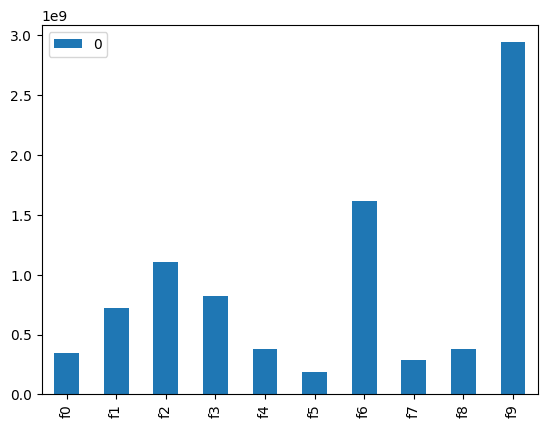

In [307]:
importance = model.get_booster().get_score(importance_type = 'gain')

importance_df = pd.DataFrame.from_dict(data=importance,orient='index')

importance_df.plot.bar()
X_train.columns

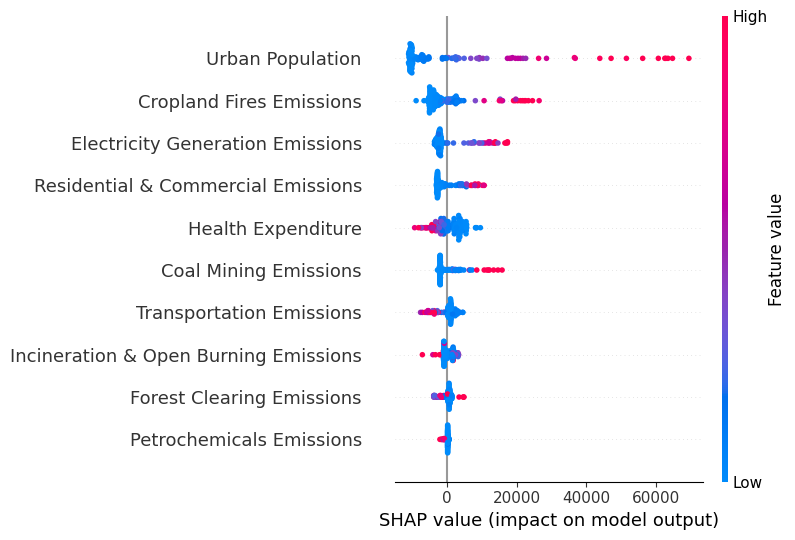

'<img src="beeswarm_plot2.png" alt="SHAP Beeswarm Plot" width="800">'

In [308]:

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

def generate_beeswarm_plot(X_train, model):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="dot")
    
    plt.figure(figsize=(10,6))
    shap.plots.beeswarm(shap_values, show=False)
    plt.savefig("beeswarm_plot2.png", bbox_inches='tight')
    plt.close()

    return '<img src="beeswarm_plot2.png" alt="SHAP Beeswarm Plot" width="800">'
generate_beeswarm_plot(X_train_scaled_df, model)

In [309]:
scatter_html_blocks = []
for column in X:
    correlation = final_merged[[column, 'Air Pollution Deaths']].corr().iloc[0, 1]
    
    fig = px.scatter(final_merged, x=column, y='Air Pollution Deaths', hover_data=['Country Code'])

    fig.add_annotation(
    x=max(final_merged[column]),
    y=max(final_merged['Air Pollution Deaths']),
    text=f"Correlation: {correlation:.4f}",
    showarrow=False,
    font=dict(size=14, color="red"))

    scatter_html_blocks.append(fig)

# for i in scatter_html_blocks:
#     i.show()

In [310]:
print("final_merged_with_outlier columns:", final_merged_with_outlier.columns)
print("final_merged columns:", final_merged.columns)

final_merged_with_outlier columns: Index(['Country Code', 'Transportation Emissions', 'Coal Mining Emissions',
       'Cropland Fires Emissions', 'Residential & Commercial Emissions',
       'Forest Clearing Emissions', 'Petrochemicals Emissions',
       'Electricity Generation Emissions',
       'Incineration & Open Burning Emissions', 'Health Expenditure',
       'Urban Population', 'Air Pollution Deaths'],
      dtype='object')
final_merged columns: Index(['Country Code', 'Transportation Emissions', 'Coal Mining Emissions',
       'Cropland Fires Emissions', 'Residential & Commercial Emissions',
       'Forest Clearing Emissions', 'Petrochemicals Emissions',
       'Electricity Generation Emissions',
       'Incineration & Open Burning Emissions', 'Health Expenditure',
       'Urban Population', 'Air Pollution Deaths'],
      dtype='object')


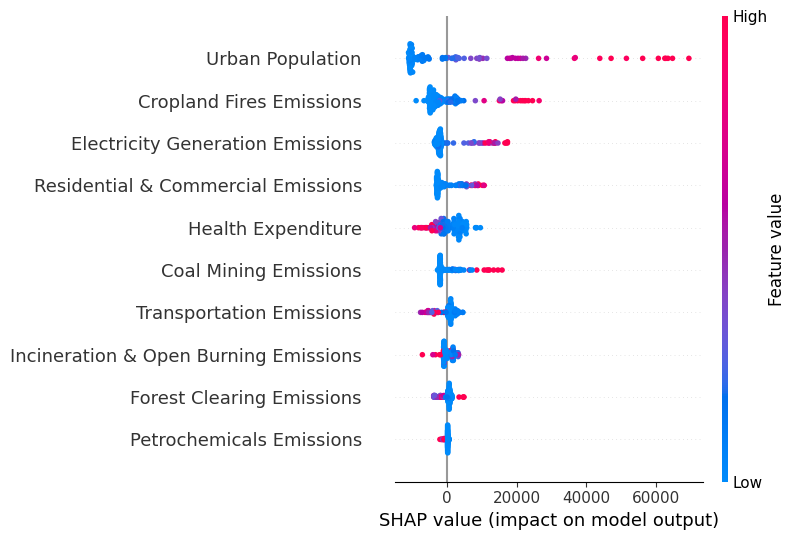

In [ ]:


def generate_html_file():
    rounded_train_r2 = round(train_r2, 2)
    rounded_test_r2 = round(test_r2, 2)
    scatter_html_blocks = []
    scatter_html_blocks_with_outlier = []
    spcounter = 1
    spcounter2 = 1

    for column in X:
        correlation = final_merged[[column, 'Air Pollution Deaths']].corr().iloc[0, 1]
        correlation_outliers = final_merged_with_outlier[[column, 'Air Pollution Deaths']].corr().iloc[0, 1]
        
        fig = px.scatter(final_merged, 
                         x=column, 
                         y='Air Pollution Deaths', 
                         hover_data=['Country Code'],
                         text=final_merged['Country Code'],
                         title= f'{column} vs Air Pollution Deaths (Excl. CHN & IND) (Correlation: {round(correlation, 2)})',
                         height=600,
                         width=1000
                         )

        
        fig.update_traces(textposition='top center', marker=dict(size=8))
        fig.update_layout(title_x=0.5, title_y=0.9)
        fig.add_annotation(
            x=max(final_merged['Health Expenditure']),
            y=max(final_merged['Air Pollution Deaths'])
        )
        fig.layout.annotations = []
        scatter_html_blocks.append(fig.to_html(full_html=False, div_id=f"scatterplot_{spcounter}")) 
        spcounter +=1

        fig_outliers = px.scatter(final_merged_with_outlier, 
                         x=column, 
                         y='Air Pollution Deaths', 
                         hover_data=['Country Code'],
                         text=final_merged_with_outlier['Country Code'],
                         title= f'{column} vs Air Pollution Deaths (Correlation: {round(correlation_outliers, 2)})',
                         height=600,
                         width=1000
                         )

        
        fig_outliers.update_traces(textposition='top center', marker=dict(size=8))
        fig_outliers.update_layout(title_x=0.5, title_y=0.9)
        fig_outliers.add_annotation(
            x=max(final_merged_with_outlier['Health Expenditure']),
            y=max(final_merged_with_outlier['Air Pollution Deaths'])
        )
        fig_outliers.layout.annotations = []
        scatter_html_blocks_with_outlier.append(fig_outliers.to_html(full_html=False, div_id=f"scatterplot_outlier_{spcounter2}")) 
        spcounter2 +=1


    choropleth_map = px.choropleth(
        factors,
        locations="Country Code",
        color="Air Pollution Deaths",
        hover_data={'Country Code': True, 'Air Pollution Deaths': True},
        color_continuous_scale=px.colors.sequential.Reds,
        labels={"Air Pollution Deaths": "Air Pollution Deaths"},
        height=600,
        width=1000
    )
    choropleth_map.update_coloraxes(colorbar=dict(
    x=1.1,   # Adjust this value as needed for horizontal positioning
    y=0.5,    # Centers the colorbar vertically
    len=0.65,  # Optional: Adjusts the length (height) of the colorbar
    # thickness=15  # Optional: Adjusts the width (thickness) of the colorbar
    
    ))
    choropleth_map.update_layout(geo=dict(showframe=False), margin=dict(r=100))
    choropleth_map = choropleth_map.to_html(full_html=False)

    with open("coding_test_output.html", "w", encoding="utf-8") as f:
        f.write(f"""
        <html>
            <head>
                <title>Air Pollution and Emissions Analysis</title>
                <link rel="stylesheet" href="styles.css" />
                <script>
                    var showingOutliers = true;
                    var gid = 0;
                    
                    function showPlot(id) {{
                        console.log("Clicked: ", id);

                        let plots;
                        let plot_id;
                        if (showingOutliers) {{
                
                            plots = document.getElementsByClassName('scatterplot_outliers');
                            plot_id = "plot_with_outliers_" + id
                            for (var i = 0; i < plots.length; i++) {{
                            plots[i].style.display = 'none';
                
                            console.log("Showing outliers? ", showingOutliers)
                            }}
                
                            }} else {{
                
                                plots = document.getElementsByClassName('scatterplot');
                                plot_id = "plot_no_outliers_" + id
                                for (var i = 0; i < plots.length; i++) {{
                                plots[i].style.display = 'none';
                
                                console.log("Showing outliers? ", showingOutliers)
                                
                            }} 
                            }}
                
                        
                        plotToShow = document.getElementById(plot_id)
                        console.log(plot_id)
                        plotToShow.style.display = 'block';
                        show = plotToShow
                        gid = id
                        }}
                
                        
                    function toggleOutliers() {{
                        showingOutliers = !showingOutliers;
                        show.style.display = 'none';
                        showPlot(gid);
        }}
                
                    window.onload = function() {{
                    showPlot("0");
            }};
                
                </script>
                
            </head>
            <body>
                <h1>Air Pollution Air Pollution Deaths by Country</h1>
                {choropleth_map}
                <hr>

                <div class="scatter-form-container">
                    <h2 class="scatter-form-title">Scatter Plot</h2>

                    <div class="form-container">
                        <div class="radio-container">
        """)

        # Generating radio buttons dynamically
        labels = [
            "Transportation Emissions", "Coal Mining Emissions", "Cropland Fires Emissions",
            "Residential & Commercial Emissions", "Forest Clearing Emissions", "Petrochemicals Emissions",
            "Electricity Generation Emissions", "Incineration & Open Burning Emissions",
            "Health Expenditure", "Urban Population"
        ]

        for i, label in enumerate(labels):
            checked_attr = "checked" if i == 0 else "";
            f.write(f"""
                <label for="{i}">
                <input type="radio" id="{i}" name="emissions" value="{label.lower().replace(' ', '_')}" onclick="showPlot(id)" {checked_attr}>
                {label}
                </label>
            """)
        f.write("""
                <div class='option-container'>
            <label for="outlierToggle">Outlier Removal Option: </label>
            <select id="outlierToggle" onchange="toggleOutliers()">
                <option value="include"  selected>Include CHN & IND</option>
                <option value="exclude">Exclude CHN & INC</option>
                
            </select>
                </div>
            """)
        f.write("""
                        </div>
                    </div>

                    <div class="scatter-container">
        """)

        for j, outlier in enumerate(scatter_html_blocks_with_outlier):
            plot_with_outliers_id = f"plot_with_outliers_{j}"
            
            display_style = 'block' if j == 0 else 'none'
            f.write(f"""
                <div id="{plot_with_outliers_id}" class="scatterplot_outliers" style="display: {display_style};">
                {outlier}</div>
                """)
        for i, scatter in enumerate(scatter_html_blocks):
            plot_no_outliers_id = f"plot_no_outliers_{i}"
            f.write(f"""
                <div id="{plot_no_outliers_id}" class="scatterplot" style="display: none;">
                    {scatter}
                </div>
            """)
        
        

        
        
        f.write(f"""
                    </div>
                </div>
            <hr>
            <div class='adjusted-score'>
                <h2>Adjusted R<sup>2</sup> Score</h2>
            </div>
                <p>Train data: <strong>{rounded_train_r2}</strong></p>
                <p id='test-data'>Test data: <strong>{rounded_test_r2}</strong></p>
            <hr>
            <h2>SHAP Beeswarm Plot</h2>
            {generate_beeswarm_plot(X_train_scaled_df, model)}
            </body>
        
        </html>
        """)

generate_html_file()


In [312]:
# Hyperparameter Optimization 

'''
import itertools
import xgboost as xgb

param_grid = {
    'n_estimators': [200, 300, 400, 600, 800],
    'learning_rate': [0.01, 0.05, 0.001, 0.1], 
    'max_depth': [1, 2, 3, 4, 5] ,
    'gamma': [0, 1, 2],
    
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.7],
    'colsample_bytree': [0.7, 0.8, 0.9, 1],
    'reg_alpha': [1, 10, 50, 100, 1000],
    'reg_lambda': [1, 5, 10, 50, 100]
}
param_combinations = itertools.product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['gamma'],
    param_grid['subsample'],
    param_grid['colsample_bytree'],
    param_grid['reg_alpha'],
    param_grid['reg_lambda']
)

# Initialize results container
results = []
count = 1

try:
    for params in param_combinations:
        n_estimators, learning_rate, max_depth, gamma, subsample, colsample_bytree, reg_alpha, reg_lambda = params

        xgb_model = xgb.XGBRegressor(
            n_estimators = n_estimators,
            learning_rate = learning_rate,
            max_depth = max_depth,
            gamma = gamma,
            subsample = subsample,
            colsample_bytree = colsample_bytree,
            reg_alpha = reg_alpha,
            reg_lambda = reg_lambda,
            random_state = random_seed
        )

        xgb_model.fit(X_train_scaled, y_train)
        
        y_train_pred = xgb_model.predict(X_train_scaled)
        y_test_pred = xgb_model.predict(X_test_scaled)

        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        print("Iteration " + str(count) + "  Test R2 Score: " + str(test_r2))
        count += 1
        # Store the results
        if test_r2 < train_r2:
            results.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'subsample': subsample,
                'gamma': gamma,
                'colsample_bytree': colsample_bytree,
                'reg_alpha': reg_alpha,
                'reg_lambda': reg_lambda,
                'train_r2': train_r2,
                'test_r2': test_r2
            })
except KeyboardInterrupt:
    print(f'Program terminated at Iteration: {count}')
    print(results)

best_params = max(results, key=lambda x: x['test_r2'])
print(f"Best Hyperparameters: {best_params}")
print(f"Best Test R² Score: {best_params['test_r2']:.4f}")
'''

'\nimport itertools\nimport xgboost as xgb\n\nparam_grid = {\n    \'n_estimators\': [200, 300, 400, 600, 800],\n    \'learning_rate\': [0.01, 0.05, 0.001, 0.1], \n    \'max_depth\': [1, 2, 3, 4, 5] ,\n    \'gamma\': [0, 1, 2],\n    \n    \'subsample\': [0.3, 0.4, 0.5, 0.6, 0.7],\n    \'colsample_bytree\': [0.7, 0.8, 0.9, 1],\n    \'reg_alpha\': [1, 10, 50, 100, 1000],\n    \'reg_lambda\': [1, 5, 10, 50, 100]\n}\nparam_combinations = itertools.product(\n    param_grid[\'n_estimators\'],\n    param_grid[\'learning_rate\'],\n    param_grid[\'max_depth\'],\n    param_grid[\'gamma\'],\n    param_grid[\'subsample\'],\n    param_grid[\'colsample_bytree\'],\n    param_grid[\'reg_alpha\'],\n    param_grid[\'reg_lambda\']\n)\n\n# Initialize results container\nresults = []\ncount = 1\n\ntry:\n    for params in param_combinations:\n        n_estimators, learning_rate, max_depth, gamma, subsample, colsample_bytree, reg_alpha, reg_lambda = params\n\n        xgb_model = xgb.XGBRegressor(\n           